In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from py_files import get_crew_from_api
crew_df = get_crew_from_api.main()

Pulled crew data from Pixel Starships API.
Wrote data to excel file.
Getting sprite images...
Wrote data to Wordpress db.
Here's your data frame!


In [3]:
# GET PRESTIGE DATA
# from py_files import get_prestige_from_api
# prestige_df = get_prestige_from_api.main(crew_df['CharacterDesignId'].values)

In [4]:
from py_files import get_manual_grades
grades_df = get_manual_grades.main()

retrieved manual grades from wordpress


In [5]:
from py_files import prep_model_features
feats_df = prep_model_features.main(crew_df)

Normalizing crews' ability scores...
Creating binary category variables...
Scaling numeric variables...
Ready for modeling!


In [6]:
from py_files import create_model_sets
from py_files import create_model_sets_withSubsampling

In [ ]:
feats_df.info()
feats_df.head()

# Model evaluation function

In [7]:
def eval_model(model, role, feats_df, grades_df, graphing=True):
    import matplotlib.pyplot as plt
    %matplotlib inline
    # import seaborn as sns
    # sns.set()
    
    train_features, train_labels, test_features, test_labels = create_model_sets_withSubsampling.main(feats_df, grades_df, role, p=False, N=100)
    
    # run the model on the train/test sets    
    model.fit(train_features, train_labels)
    y_pred_test = model.predict(test_features)
    
    # round predicted grades to ints between 0 and 4 (important for LR model)
    y_pred_test  = np.round(y_pred_test , 0)
    y_pred_test[y_pred_test <0] = 0
    y_pred_test[y_pred_test >4] = 4
    
    # accuracy
    acc = round(sum(y_pred_test  == test_labels)/test_labels.shape[0],3)*100
    
    # what if you consider +/- 1 star to be still "accurate"?
    acc2 = round((
        sum(y_pred_test  == test_labels) + 
        sum(y_pred_test  == test_labels-1) + sum(y_pred_test == test_labels+1)
        )/test_labels.shape[0],3)*100
    print("\n\nThe classifier had an accuracy of " 
          + str(acc) + "% (and a +/-1 grade accuracy of " + str(acc2) + "%) on the " + role + " test set." )  
    
    # print("\n The model achieves an R2 value of " + str(model.score(test_features, test_labels)) + " on the " + role + " test set.")
   
    
    # for each character in the grades list, put the label in the "grade" column
    df = feats_df.copy()
    df['grade'] = None  # default is no grade
       
    for ind in range(len(grades_df)):
        g = grades_df[f"{role + 'Input'}"].values[ind]
        df.set_value(df.CharacterDesignId == grades_df['CharacterDesignId'].values[ind], 'grade', g)
    
    graded_crew = df[df.grade.isnull() == False].reset_index(drop=True)
    y_pred_all = model.predict(graded_crew.drop(['CharacterDesignId', 'grade'], axis=1))
    # round predicted grades to ints between 0 and 4 (important for LR model)
    y_pred_all = np.round(y_pred_all, 0)
    y_pred_all[y_pred_all <0] = 0
    y_pred_all[y_pred_all >4] = 4
    
    # Plotting
    if graphing:
        plt.figure(figsize = (40,10))
        boundaries = [1.5, 2.5, 3.5]
    
        # plot test grades
        plt.subplot(1,3,1)
        plt.title('Test Set Grading')
        plt.xlabel('manual grades')
        plt.ylabel('model grades')
        plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred_test))*0.2, y_pred_test, marker ='+', color = 'blue')
        for v in boundaries:
            plt.plot([0,5], [v,v], color='gray')
    
        # plot all grades
        plt.subplot(1,3,2)
        plt.title('All Crew Grading')
        plt.xlabel('manual grades')
        plt.ylabel('model grades')
        plt.scatter(graded_crew['grade']+0.1-np.random.uniform(size=len(y_pred_all))*0.2, y_pred_all, marker ='+', color = 'blue')
        for v in boundaries:
            plt.plot([0,5], [v,v], color='gray')
        
        plt.show()
    
    return graded_crew['CharacterDesignId'], graded_crew['grade'], y_pred_all;

In [8]:
def show_errors(ids, manual_grades, model_grades, crew_df):
        for ind in range(len(ids)):
            if manual_grades[ind] > 1.9 or model_grades[ind] > 1.9:  
            # only worry about 2,3,4 grades. 0 and 1 aren't going into the post
                if round(model_grades[ind], 0) != manual_grades[ind]:
                    # bad grading
                    crewloc = crew_df['CharacterDesignId'].values.tolist().index(ids[ind])
                    crewname = crew_df['CharacterDesignName'].values[crewloc]
                    print('Prediction error: ' + crewname + 
                          ' should be ' + str(manual_grades[ind]) + ' but the model predicts ' + 
                          str(round(model_grades[ind], 2)))

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# linear regression model
e = False
graphing = True

Regmodel = LinearRegression()
ids, manual_g, model_g = eval_model(Regmodel, 'Gunner', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)
    


In [ ]:
m4_ids = ids[model_g == 4]
len(m4_ids)
m4_stats = pd.DataFrame()

for id in m4_ids:
    row = feats_df[feats_df['CharacterDesignId']==id]
    m4_stats = m4_stats.append(row)

print(len(m4_stats))

m4_stats.mean(axis=0)



The classifier had an accuracy of 84.0% (and a +/-1 grade accuracy of 99.2%) on the Gunner test set.


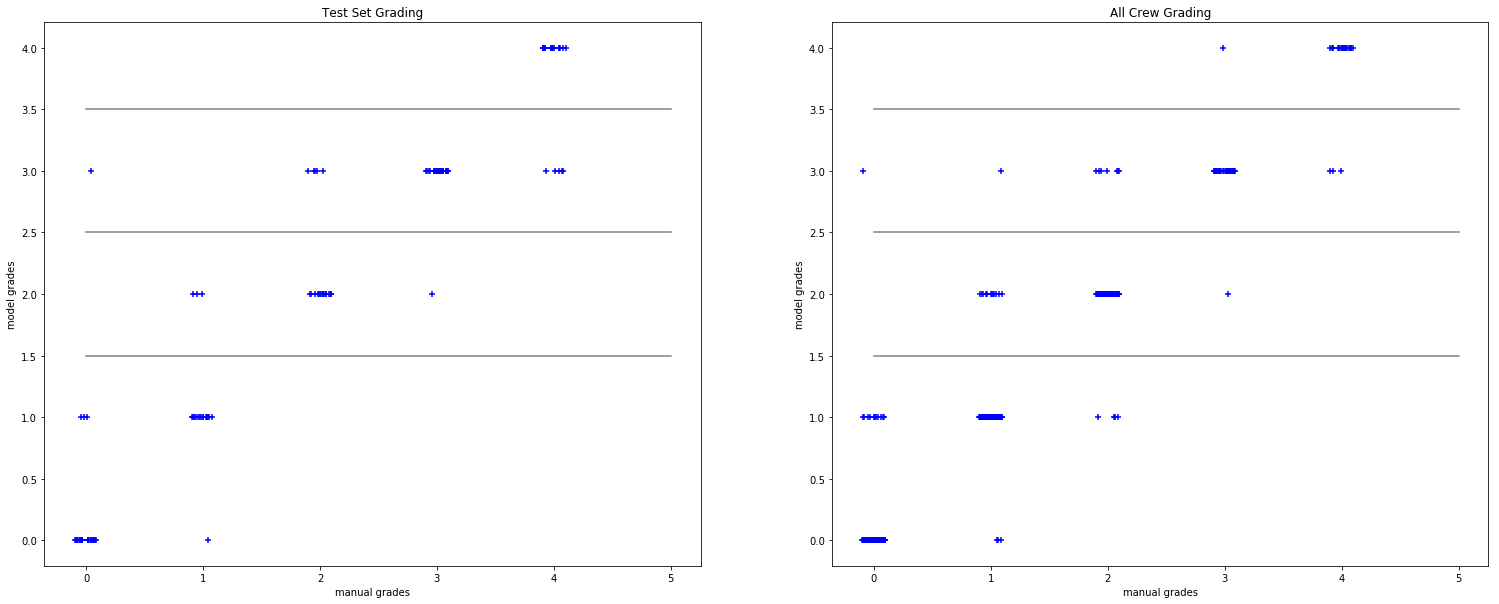



The classifier had an accuracy of 78.2% (and a +/-1 grade accuracy of 100.0%) on the Shielder test set.


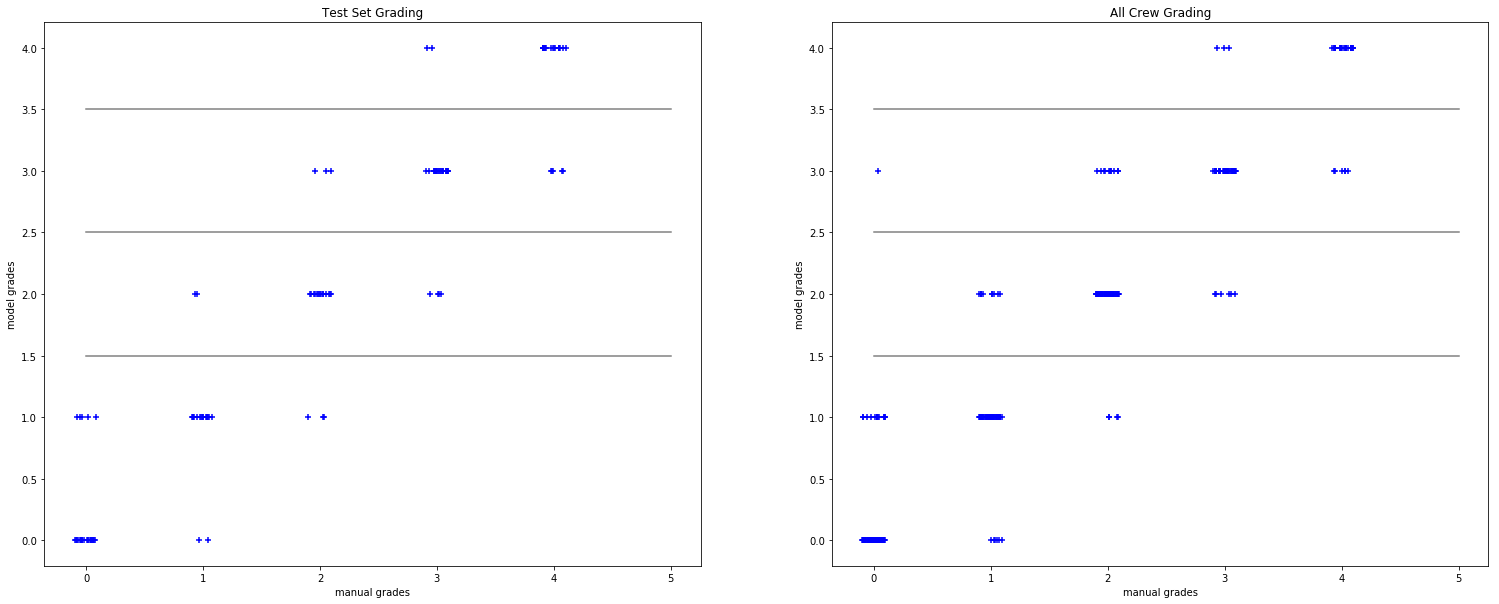



The classifier had an accuracy of 87.4% (and a +/-1 grade accuracy of 100.0%) on the Engineer test set.


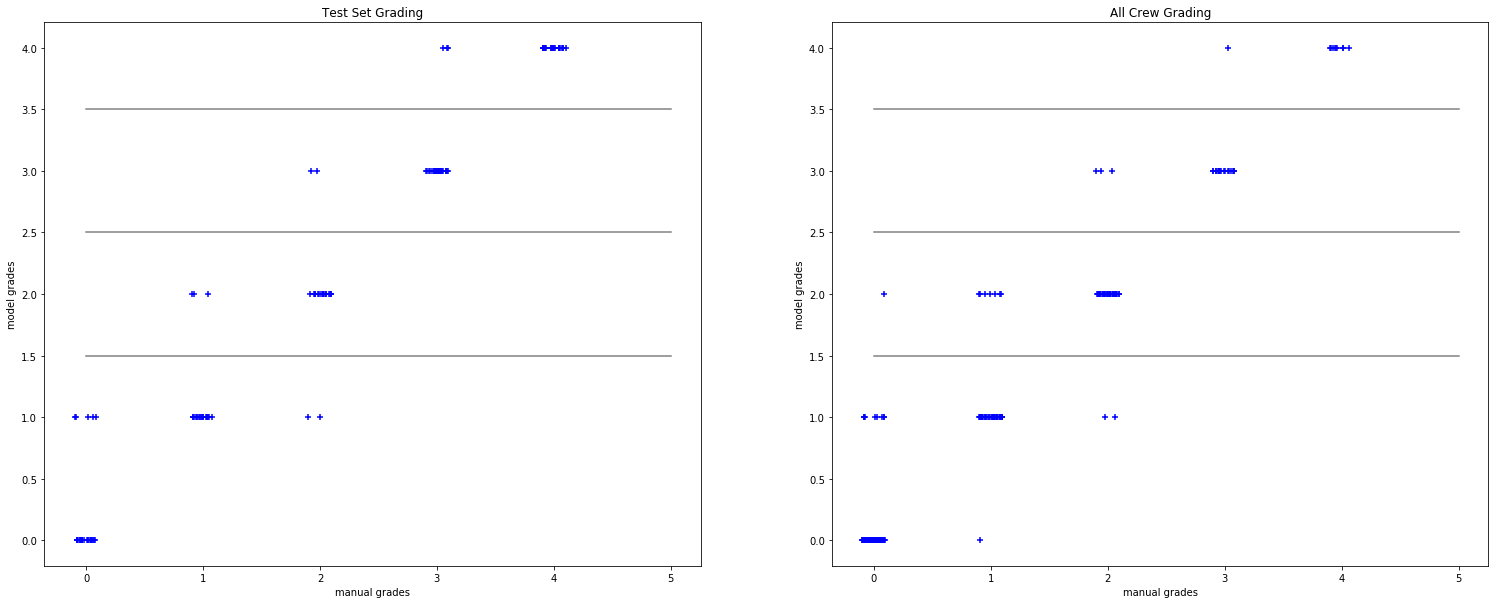



The classifier had an accuracy of 84.9% (and a +/-1 grade accuracy of 98.3%) on the Pilot test set.


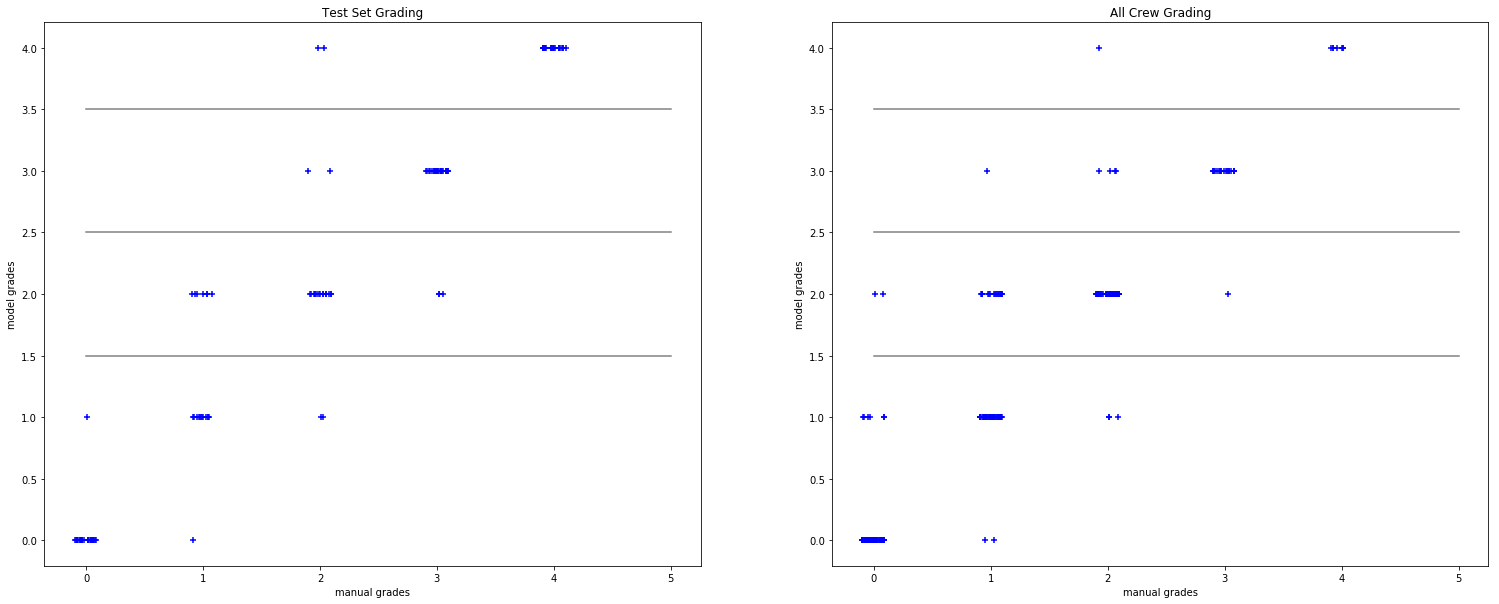



The classifier had an accuracy of 77.3% (and a +/-1 grade accuracy of 99.2%) on the Repairer test set.


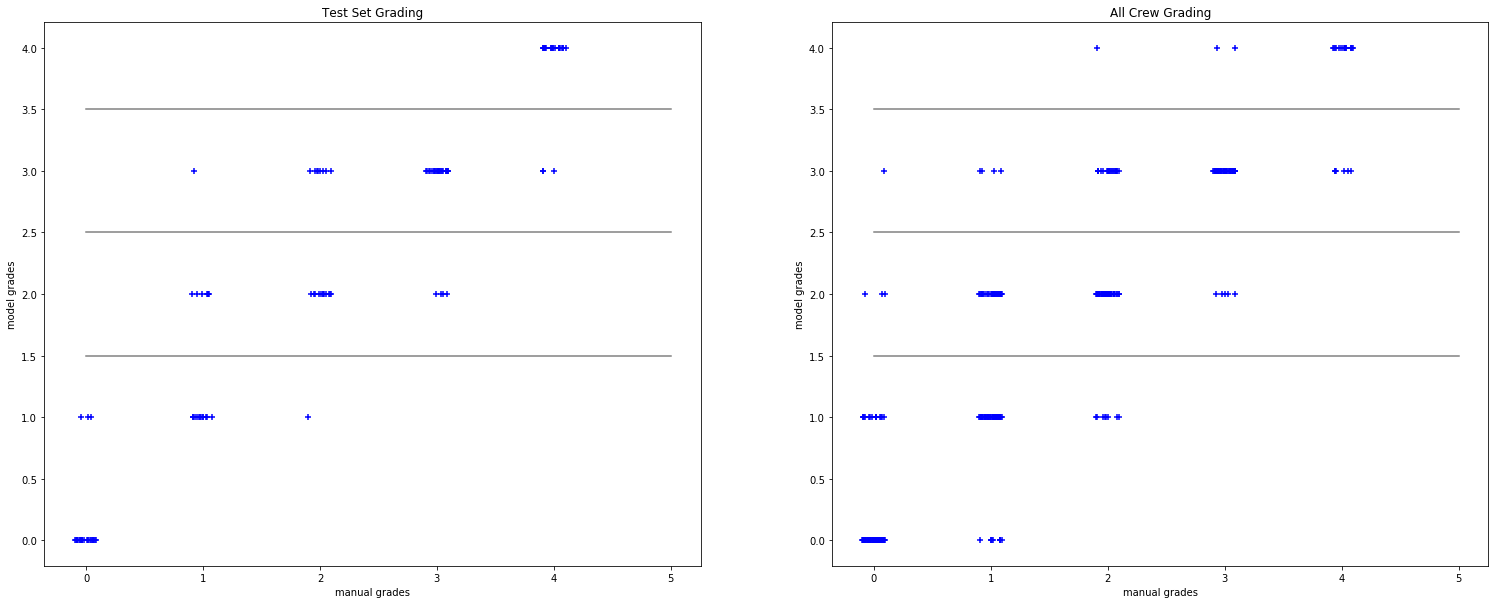



The classifier had an accuracy of 79.0% (and a +/-1 grade accuracy of 98.3%) on the Antiboarder test set.


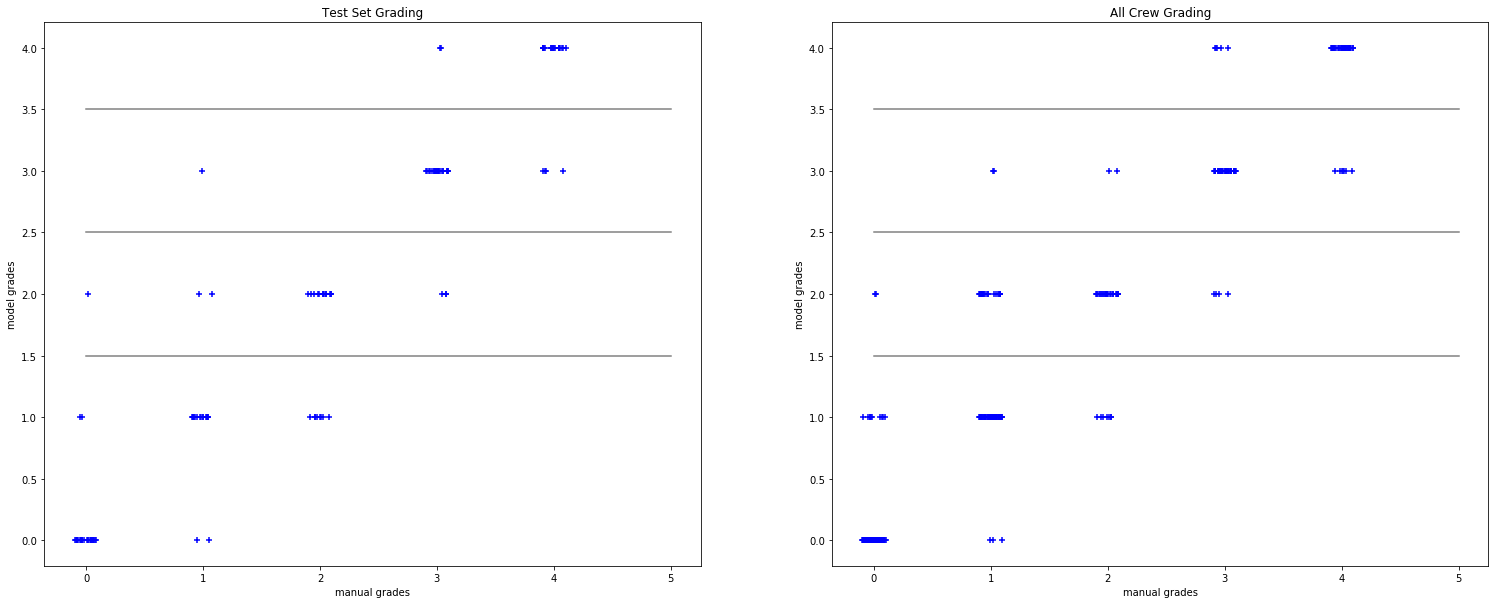



The classifier had an accuracy of 84.0% (and a +/-1 grade accuracy of 99.2%) on the Boarder test set.


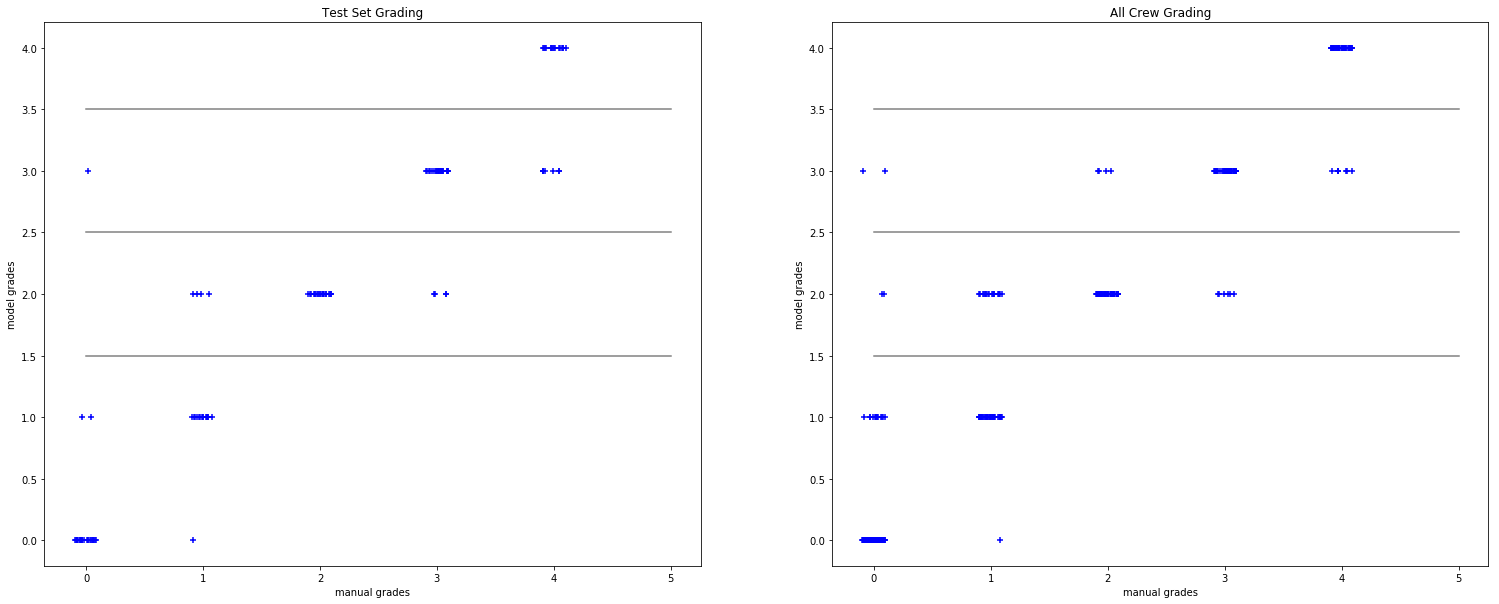



The classifier had an accuracy of 93.9% (and a +/-1 grade accuracy of 100.0%) on the Rusher test set.


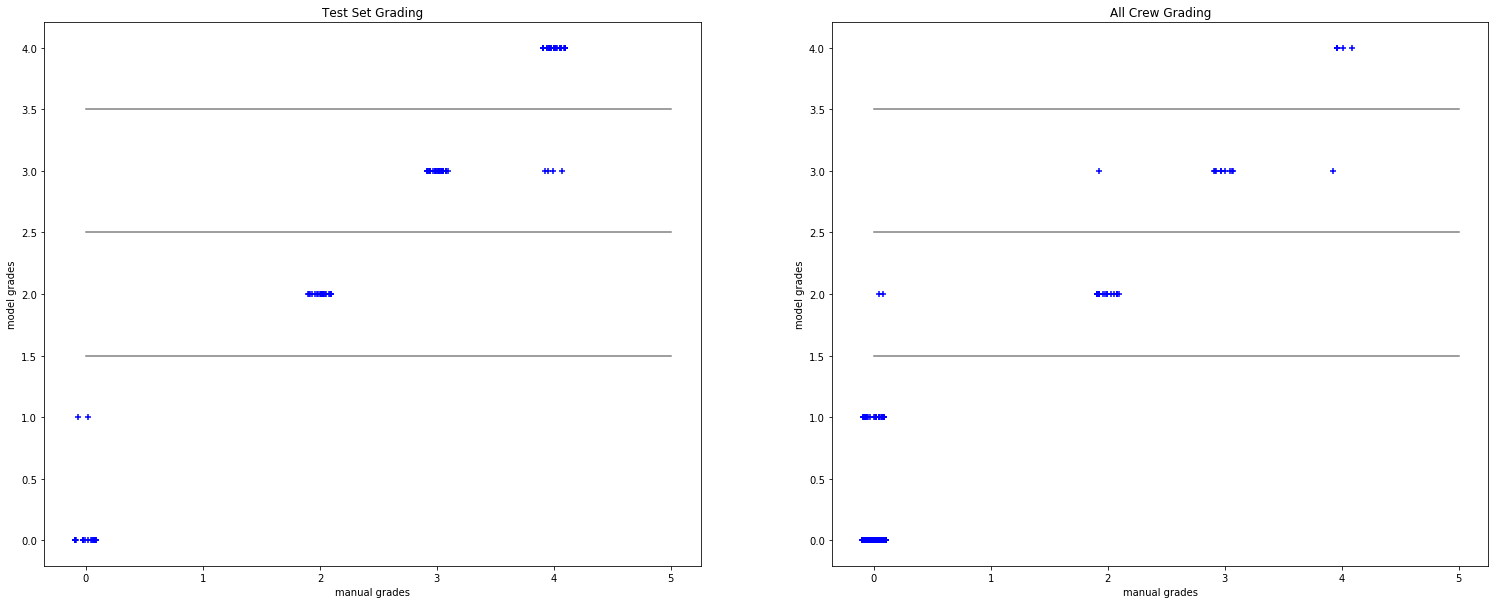

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np

# linear regression model
e = False
graphing = True

Regmodel = LinearRegression()
ids, manual_g, model_g = eval_model(Regmodel, 'Gunner', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(Regmodel, 'Shielder', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(Regmodel, 'Engineer', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(Regmodel, 'Pilot', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(Regmodel, 'Repairer', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(Regmodel, 'Antiboarder', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(Regmodel, 'Boarder', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(Regmodel, 'Rusher', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

In [ ]:
# what are the most important features?
n=15
coefs = Regmodel.coef_
top_feat_inds = np.fliplr([np.argsort(coefs)[-n:]])[0]
bottom_feat_inds = np.argsort(coefs)[0:n]

# features that bring rating up
for i in top_feat_inds:
    print("The feature " + feats_df.columns.tolist()[i+1] +   # one label later, since we dropped CrewId after model_data
          " has a coefficient of " +  str(coefs[i]))
print("\n")
# features that bring rating down
for i in bottom_feat_inds:
    print("The feature " + feats_df.columns.tolist()[i+1] + 
          " has a coefficient of " +  str(coefs[i]))

# kNN

In [ ]:
# kNN model
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier(n_neighbors = 5)

e = False
graphing = True

ids, manual_g, model_g = eval_model(kNN, 'Gunner', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(kNN, 'Shielder', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(kNN, 'Engineer', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(kNN, 'Pilot', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(kNN, 'Repairer', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(kNN, 'Antiboarder', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(kNN, 'Boarder', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(kNN, 'Rusher', feats_df, grades_df, graphing)
if e: show_errors(ids, manual_g, model_g, crew_df)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1,3,5,7,9]

for k in k_values:  
    
    kNN = KNeighborsClassifier(n_neighbors = k)
    kNN.fit(train_features, train_labels)
    
    # take a stab at the test set
    y_pred = kNN.predict(test_features)
    # accuracy
    acc = round(sum(y_pred == test_labels)/test_labels.shape[0],3)*100
    
    # what if you consider +/- 1 star to be still "accurate"?
    acc2 = round((
        sum(y_pred == test_labels) + 
        sum(y_pred == test_labels-1) + sum(y_pred == test_labels+1)
        )/test_labels.shape[0],3)*100
    print("The kNN classifier with k=" + str(k) + " had an accuracy of " 
          + str(acc) + "% (and a +/-1 grade accuracy of " + str(acc2) + "%)." )

In [ ]:
# use the best model: n = 1
kNN = KNeighborsClassifier(n_neighbors = 1)
kNN.fit(train_features, train_labels)

# print the values the model gets wrong
print("\nThe ratings misclassified by the classifier were: ")
y_pred = kNN.predict(test_features)
errors = test_labels[y_pred != test_labels]
print(str(y_pred[y_pred != test_labels]) + "-- predicted values")
print(str(errors) + "-- actual values")

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np
# logistic regression model
LogRegmodel = LogisticRegression(multi_class = 'multinomial', solver='newton-cg')

ids, manual_g, model_g = eval_model(LogRegmodel, 'Gunner', feats_df, grades_df, graphing=False)
# show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(LogRegmodel, 'Shielder', feats_df, grades_df, graphing=False)
# show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(LogRegmodel, 'Engineer', feats_df, grades_df, graphing=False)
# show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(LogRegmodel, 'Pilot', feats_df, grades_df, graphing=False)
# show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(LogRegmodel, 'Repairer', feats_df, grades_df, graphing=False)
# show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(LogRegmodel, 'Antiboarder', feats_df, grades_df, graphing=False)
# show_errors(ids, manual_g, model_g, crew_df)

ids, manual_g, model_g = eval_model(LogRegmodel, 'Boarder', feats_df, grades_df, graphing=False)
# show_errors(ids, manual_g, model_g, crew_df)

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# logistic regression model
LogRegmodel = LogisticRegression(multi_class = 'multinomial', solver='newton-cg')
LogRegmodel.fit(train_features, train_labels)

print("The logistic regression model achieves an R2 value of " + str(LogRegmodel.score(test_features, test_labels)))

# print the values the model gets wrong
print("\nThe ratings misclassified by the classifier were: ")
y_pred = LogRegmodel.predict(test_features)
errors = test_labels[y_pred != test_labels]
print(str(y_pred[y_pred != test_labels]) + "-- predicted values")
print(str(errors) + "-- actual values")

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)

# Perceptron

In [ ]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron()
perceptron.fit(train_features, train_labels)

print("The perceptron model achieves an R2 value of " + str(perceptron.score(test_features, test_labels)))
y_pred = perceptron.predict(test_features)

# print the values the model gets wrong
print("\nThe ratings misclassified by the classifier were: ")
y_pred = perceptron.predict(test_features)
errors = test_labels[y_pred != test_labels]
print(str(y_pred[y_pred != test_labels]) + "-- predicted values")
print(str(errors) + "-- actual values")

# SVM

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='poly', degree=8)
svc.fit(train_features, train_labels)

print("The svm model achieves an R2 value of " + str(svc.score(test_features, test_labels)))
y_pred = svc.predict(test_features)

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)

 # Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(train_features, train_labels)

print("The decision tree achieves an R2 value of " + str(tree.score(test_features, test_labels)))
y_pred = tree.predict(test_features)

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,2)
plt.scatter(test_labels+0.1-np.random.uniform(size=len(y_pred))*0.2, y_pred+0.1-np.random.uniform(size=len(y_pred))*0.2)